# Zadanie 1

## ZADANIE NALEŻY WYKONAĆ SAMODZIELNIE

## NIEDOZWOLONE JEST KOPIOWANIE GOTOWEGO KODU

## PROSZĘ PRZECZYTAĆ NOTEBOOK "ZADANIA_DOMOWE_HOWTO"

## TERMIN: 28 PAŹDZIERNIKA 2018 R. GODZ. 23:59



Zaimplementować następujące optimizery:

* Momentum
* Nesterov
* Adagrad
* RMSProp
* Adadelta
* Adam

Optimizery muszą mieć API takie, jak podano poniżej. Proszę nie definiować dodatkowych metod, tylko uzupełnić podane.

`__init__` przyjmuje:
* `initial_params` - słownik tablic typu numpy.ndarray, które przechowują parametry trenowanego modelu; na wykładzie oznaczone jako wektor $\theta_0$ - proszę __nie__ przekształcać tych tablic do postaci jednego wektora; wszystkie operacje opisane na wykładzie działają na parametry element-wise, proszę operować od razu na tych tablicach, stosując odpowiednie metody z paczki numpy
* pozostałe parametry optimizera

`step` przyjmuje:
* słownik tablic przechowujących wartość obliczonego gradientu; klucze słownika są zgodne z `initial_params`

i wykonuje jeden krok optimizera

`get_params` zwraca słownik aktualnych wartości $\theta$; klucze słownika muszą być zgodne z danymi podanymi w `initial_params`

Jak wiemy z wykładu, optimizer `Nesterov` działa nieco inaczej. W związku z tym musimy zdefiniować dwa warianty metody `get_params` oraz dodatkowy parametr `training_phase`. Jeśli `training_phase` ustawiony jest na `True`, optimizer powinien zwrócić parametry "patrząc wprzód", czyli takie, dla których faktycznie chcemy policzyć w danym kroku wartość gradientu funkcji kosztu - w tym celu następuje wywołanie metody `_get_training_params`. Jeśli natomiast `training_phase` ustawiony jest na `False`, należy zwrócić po prostu bieżącą wartość przechowywanych parametrów - w tym celu wołana jest metoda `_get_test_params`. Obie te metody mają zwracać słownik.

Pozostałe optimizery nie powinny w ogóle definiować parametru `training_phase`.

Dla przykładu podana jest implementacja optimizera `GradientDescent`.

In [77]:
import numpy as np

class Optimizer:

    def __init__(self, initial_params):
        assert isinstance(initial_params, dict)
        assert all([isinstance(v, np.ndarray) for v in initial_params.values()])
        assert all([v.size > 0 for v in initial_params.values()])
        self._params = {k: v.copy() for k, v in initial_params.items()}

    def get_params(self):
        return {k: v.copy() for k, v in self._params.items()}

    def get_keys(self):
        return set(self._params.keys())

    def step(self, gradients):
        raise NotImplementedError()

class GradientDescent(Optimizer):

    def __init__(self, initial_params, learning_rate):
        super().__init__(initial_params)
        self.learning_rate = learning_rate

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        for k in gradients:
            self._params[k] -= self.learning_rate * gradients[k]

class Momentum(Optimizer):

    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.momentum = {key: np.zeros(initial_params[key].shape) for key in initial_params.keys()}

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        for k in gradients:
            self.momentum[k] = self.momentum[k] * self.gamma + self.learning_rate * gradients[k]
            self._params[k] -= self.momentum[k]



class Nesterov(Optimizer):

    def __init__(self, initial_params, learning_rate, gamma):
        super().__init__(initial_params)
        self.training_phase = True
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.momentum = {param: np.zeros(initial_params[param].shape) for param in initial_params}

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        for param in gradients:
            self.momentum[param] = self.gamma * self.momentum[param] + self.learning_rate * gradients[param]
            self._params[param] -= self.momentum[param]

    def _get_training_params(self):
        tmp_momentum = {param: np.zeros(self._params[param].shape) for param in self._params.keys()}
        training_params = {param: np.zeros(self._params[param].shape) for param in self._params.keys()}
        for param in self._params.keys():
            tmp_momentum[param] = self.gamma * self.momentum[param]
            training_params[param] = self._params[param] - tmp_momentum[param]
        return training_params

    def _get_test_params(self):
        return super().get_params()

    def get_params(self):
        if self.training_phase:
            return self._get_training_params()
        else:
            return self._get_test_params()


class Adagrad(Optimizer):

    def __init__(self, initial_params, learning_rate, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.h = {param: np.zeros(initial_params[param].shape) for param in initial_params}

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        for param in gradients:
            self.h[param] += np.square(gradients[param])
            self._params[param] -= self.learning_rate * (gradients[param] / np.sqrt(self.h[param] + self.epsilon))


class RMSProp(Optimizer):

    def __init__(self, initial_params, learning_rate, gamma, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.h = {param: np.zeros(initial_params[param].shape) for param in initial_params}

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        for param in self._params.keys():
            self.h[param] = self.gamma * self.h[param] + (1 - self.gamma) * (np.square(gradients[param]))
            self._params[param] -= self.learning_rate * (gradients[param] / np.sqrt(self.h[param] + self.epsilon))


class Adadelta(Optimizer):

    def __init__(self, initial_params, gamma, epsilon):
        super().__init__(initial_params)
        self.gamma = gamma
        self.epsilon = epsilon
        self.h = {param: np.zeros(initial_params[param].shape) for param in initial_params}
        self.d = {param: np.zeros(initial_params[param].shape) for param in initial_params}
        # UZUPEŁNIĆ

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        prev_step_params = {k: v.copy() for k, v in self._params.items()}
        for param in gradients:
            self.h[param] = self.gamma * self.h[param] + (1 - self.gamma) * np.square(gradients[param])
            self._params[param] -= np.sqrt(self.d[param] + self.epsilon) * (
                    gradients[param] / np.sqrt(self.h[param] + self.epsilon))
            self.d[param] = self.gamma * self.d[param] + (1 - self.gamma) * np.square(self._params[param] - prev_step_params[param])


class Adam(Optimizer):

    def __init__(self, initial_params, learning_rate, beta1, beta2, epsilon):
        super().__init__(initial_params)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
        self.steps = 0
        self.m = {param: np.zeros(initial_params[param].shape) for param in initial_params}
        self.v = {param: np.zeros(initial_params[param].shape) for param in initial_params}
        # UZUPEŁNIĆ

    def step(self, gradients):
        assert set(gradients.keys()) == set(self._params.keys())
        self.steps += 1
        est_m = {param: np.zeros(len(self._params[param])) for param in self._params}
        est_v = {param: np.zeros(len(self._params[param])) for param in self._params}
        for param in self._params.keys():
            self.m[param] = self.beta1 * self.m[param] + (1 - self.beta1) * gradients[param]
            self.v[param] = self.beta2 * self.v[param] + (1 - self.beta2) * np.square(gradients[param])
            est_m[param] = self.m[param] / (1 - self.beta1 ** self.steps)
            est_v[param] = self.v[param] / (1 - self.beta2 ** self.steps)
            self._params[param] -= self.learning_rate * est_m[param] / (np.sqrt(est_v[param]) + self.epsilon)

        # UZUPEŁNIĆ


In [79]:
%matplotlib notebook

from src.zadanie1 import (
    ExpPoly2D,
    draw_contours,
    draw_surface,
    Fun1,
    animate,
)

def training_loop(f, opt, n_steps):
    for _ in range(n_steps):
        opt.training_phase = True # Nesterov
        params = opt.get_params()
        grad = f.gradient(params)
        opt.step(grad)
        opt.training_phase = False # Nesterov
        yield opt.get_params()

# TESTUJEMY API SŁOWNIKOWE
# W TYM WYPADKU ROZBICIE THETA NA 2 CZĘŚCI NIE MA SENSU (POZA TESTOWANIEM API)
rng = np.random.RandomState(seed=43)
initial_params = {
    "theta_a": rng.uniform(low=-5, high=5, size=(10,2)),
    "theta_b": rng.uniform(low=-5, high=5, size=(8,2)),
}

<IPython.core.display.Javascript object>


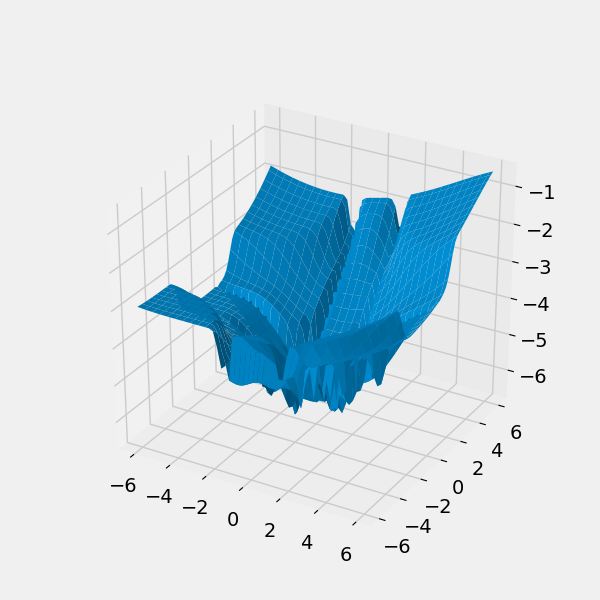

In [80]:
draw_surface(Fun1)

<IPython.core.display.Javascript object>


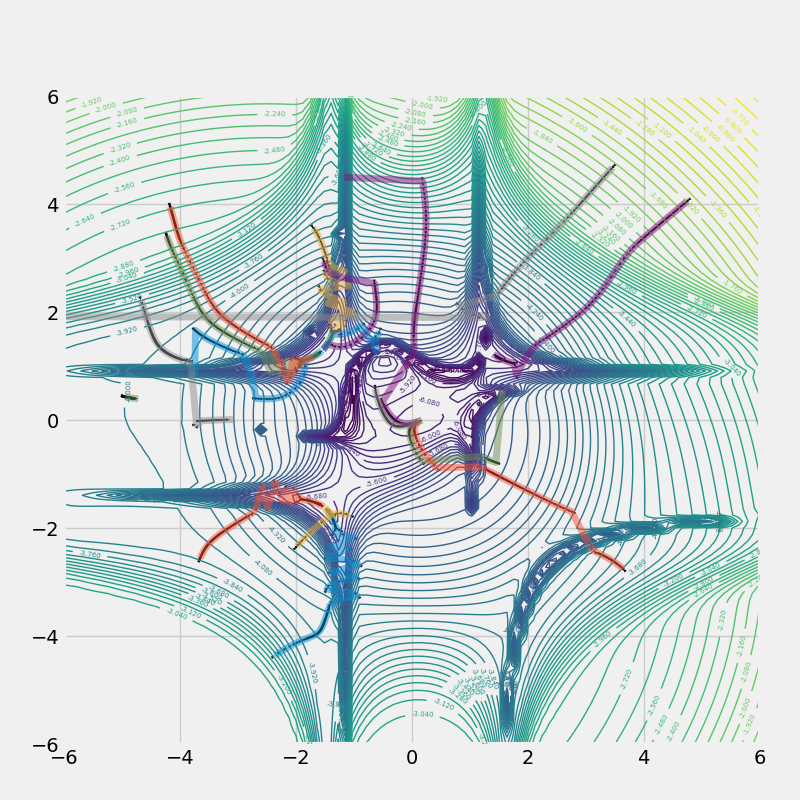

In [93]:
# GRADIENT DESCENT
animate(
    Fun1,
    training_loop(
        f=Fun1,
        opt=GradientDescent(
            initial_params=initial_params,
            learning_rate=0.1,
        ),
        n_steps=100
    )
)

<IPython.core.display.Javascript object>


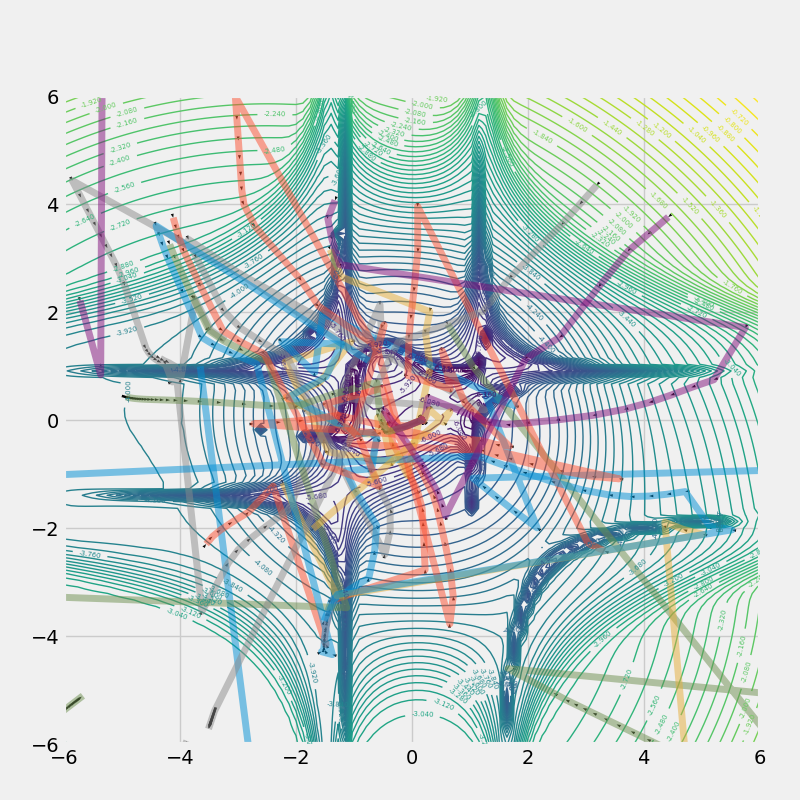

In [94]:
# GRADIENT DESCENT, ZA DUŻE LEARNING RATE
animate(
    Fun1,
    training_loop(
        f=Fun1,
        opt=GradientDescent(
            initial_params=initial_params,
            learning_rate=1.,
        ),
        n_steps=50
    )
)

<IPython.core.display.Javascript object>


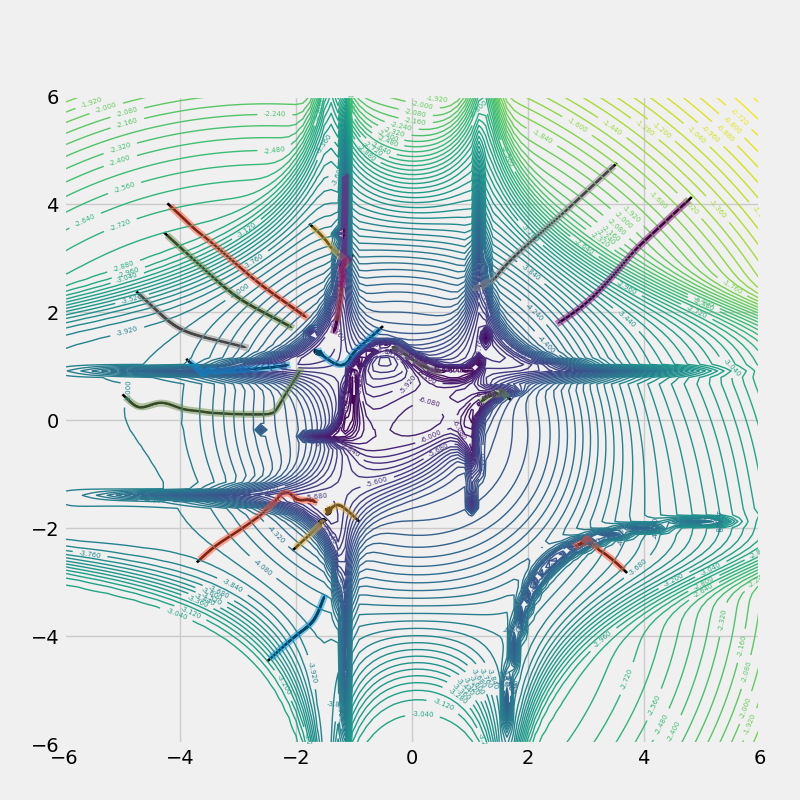

In [95]:
# ADAM
animate(
    Fun1,
    training_loop(
        f=Fun1,
        opt=Adam(
            initial_params=initial_params,
            learning_rate=0.01,
            beta1=.9,
            beta2=.999,
            epsilon=1e-8
        ),
        n_steps=200
    )
)

In [85]:
from src.zadanie1 import opt_assert

In [86]:
opt_assert(opt_cls=GradientDescent, opt_kwargs={"learning_rate": .143})

GradientDescent {'learning_rate': 0.143}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params - after step 1:
  theta_piesek: [ 0.287  0.144  0.001 -0.142]
  theta_konik : [3.728 3.156 2.584]
  theta_rybka : [0.271]
optimizer params - after step 2:
  theta_piesek: [ 1.000e-03 -4.280e-01 -8.570e-01 -1.286e+00]
  theta_konik : [3.013 1.726 0.439]
  theta_rybka : [-0.301]
optimizer params - after step 3:
  theta_piesek: [-0.428 -1.286 -2.144 -3.002]
  theta_konik : [ 2.155  0.01  -2.135]
  theta_rybka : [-1.016]


In [87]:
opt_assert(opt_cls=Momentum, opt_kwargs={"learning_rate": .143, "gamma": .943})

Momentum {'learning_rate': 0.143, 'gamma': 0.943}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params - after step 1:
  theta_piesek: [ 0.287  0.144  0.001 -0.142]
  theta_konik : [3.728 3.156 2.584]
  theta_rybka : [0.271]
optimizer params - after step 2:
  theta_piesek: [-0.133849 -0.697698 -1.261547 -1.825396]
  theta_konik : [ 2.473604  0.647208 -1.179188]
  theta_rybka : [-0.705547]
optimizer params - after step 3:
  theta_piesek: [-0.95970961 -2.34941921 -3.73912882 -5.12883843]
  theta_konik : [ 0.43270857 -3.43458286 -7.30187428]
  theta_rybka : [-2.34143082]


In [88]:
opt_assert(opt_cls=Nesterov, opt_kwargs={"learning_rate": .143, "gamma": .943})

Nesterov {'learning_rate': 0.143, 'gamma': 0.943}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params (training_phase == True) - after step 1:
  theta_piesek: [ 0.152151 -0.125698 -0.403547 -0.681396]
  theta_konik : [3.188604 2.077208 0.965812]
  theta_rybka : [-0.133547]
optimizer params (training_phase == True) - after step 1:
  theta_piesek: [ 0.287  0.144  0.001 -0.142]
  theta_konik : [3.728 3.156 2.584]
  theta_rybka : [0.271]
optimizer params (training_phase == True) - after step 2:
  theta_piesek: [-0.53070961 -1.49141921 -2.45212882 -3.41283843]
  theta_konik : [ 1.29070857 -1.71858286 -4.72787428]
  theta_rybka : [-1.62643082]
optimizer params (training_phase == True) - after step 2:
  theta_piesek: [-0.133849 -0.697698 -1.261547 -1.825396]
  theta_konik : [ 2.473604  0.647208 -1.179188]
  theta_rybka : [-0.705547]
optimizer params (training_phase == True) - after step 3:
  theta_piesek: [-1.73849616 -3.9

In [89]:
opt_assert(opt_cls=Adagrad, opt_kwargs={"learning_rate": .143, "epsilon": .001})

Adagrad {'learning_rate': 0.143, 'epsilon': 0.001}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params - after step 1:
  theta_piesek: [0.28707145 0.28701787 0.28700794 0.28700447]
  theta_konik : [4.15700447 4.15700112 4.1570005 ]
  theta_rybka : [0.55700794]
optimizer params - after step 2:
  theta_piesek: [0.15918115 0.15911798 0.15910628 0.15910218]
  theta_konik : [4.04534159 4.04533722 4.04533641]
  theta_rybka : [0.44261023]
optimizer params - after step 3:
  theta_piesek: [0.04453017 0.04446393 0.04445166 0.04444736]
  theta_konik : [3.94756405 3.9475592  3.9475583 ]
  theta_rybka : [0.34149497]


In [90]:
opt_assert(opt_cls=RMSProp, opt_kwargs={"learning_rate": .143, "gamma": .9, "epsilon": .001})

RMSProp {'learning_rate': 0.143, 'gamma': 0.9, 'epsilon': 0.001}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params - after step 1:
  theta_piesek: [-0.01996149 -0.02164151 -0.02195469 -0.02206446]
  theta_konik : [3.84793554 3.84782962 3.84781   ]
  theta_rybka : [0.24804531]
optimizer params - after step 2:
  theta_piesek: [-0.42811665 -0.43010875 -0.4304798  -0.43060983]
  theta_konik : [3.48776945 3.48762925 3.48760328]
  theta_rybka : [-0.12033586]
optimizer params - after step 3:
  theta_piesek: [-0.79843995 -0.80053557 -0.8009258  -0.80106255]
  theta_konik : [3.16682831 3.16667127 3.16664217]
  theta_rybka : [-0.4511984]


In [91]:
opt_assert(opt_cls=Adadelta, opt_kwargs={"gamma": .95, "epsilon": .001})

Adadelta {'gamma': 0.95, 'epsilon': 0.001}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params - after step 1:
  theta_piesek: [0.28997199 0.28893088 0.28873552 0.28866695]
  theta_konik : [4.15866695 4.15860074 4.15858846]
  theta_rybka : [0.55873552]
optimizer params - after step 2:
  theta_piesek: [0.11142917 0.10945862 0.1090889  0.10895913]
  theta_konik : [4.00103532 4.00090279 4.00087822]
  theta_rybka : [0.397431]
optimizer params - after step 3:
  theta_piesek: [-0.10360851 -0.1066266  -0.10719291 -0.10739167]
  theta_konik : [3.82507607 3.82487242 3.82483468]
  theta_rybka : [0.21412134]


In [92]:
opt_assert(opt_cls=Adam, opt_kwargs={"learning_rate": .143, "beta1": .943, "beta2": .9943, "epsilon": .001})

Adam {'learning_rate': 0.143, 'beta1': 0.943, 'beta2': 0.9943, 'epsilon': 0.001}
initial params:
  theta_piesek: [0.43 0.43 0.43 0.43]
  theta_konik : [4.3 4.3 4.3]
  theta_rybka : [0.7]
optimizer params - after step 1:
  theta_piesek: [0.28714286 0.28707146 0.28704765 0.28703574]
  theta_konik : [4.15703574 4.15701787 4.15701192]
  theta_rybka : [0.55704765]
optimizer params - after step 2:
  theta_piesek: [0.1503583  0.1502437  0.15020548 0.15018636]
  theta_konik : [4.01452327 4.01448968 4.01447847]
  theta_rybka : [0.41498861]
optimizer params - after step 3:
  theta_piesek: [0.01565974 0.01551402 0.01546542 0.01544112]
  theta_konik : [3.87242241 3.87237479 3.87235892]
  theta_rybka : [0.27367191]
